# Logistic Regression Using Scikit-Learn

The following topics are convered in this notebook

* Downloading a real-world dataset from kaggle
* Exploratory data analysis and visualization
* Splitting a dataset into training, valiation and test sets
* Filling/imputing missing values in numeric columns
* Scaling numeric features to a (0,1) range
* Encoding categorical columns as one-hot vactors
* Training a logistic regression model using Scikit-learn
* Evaluating a model using a validataion set and test set
* Saving a model to disk and loading it back

In [1]:
import requests, zipfile, pathlib
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [2]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
# !pip install opendatasets --upgrade --quiet

In [4]:
# import opendatasets as od

In [5]:
# Set up our dataset path

dataset_path = Path("weather-dataset-rattle-package/")
# dataset_path = data_path / "weather-dataset-rattle-package"

# If dataset path does not exist, make it
if dataset_path.is_dir():
  print(f"{dataset_path} already exists, skipping creation")

else:
  print(f"{dataset_path} does not exist, creating one...")
  dataset_path.mkdir(parents = True, exist_ok = True)

# Download dataset from github
with open(dataset_path / "archive.zip", "wb") as f:
  request = requests.get(("https://github.com/Musawer-Afzal/ML-with-Scikit-Learn-in-Python/raw/refs/heads/master/Datasets/archive.zip"))
  print("Downloading Austrailia Weather Dataset")
  f.write(request.content)

# Unzip the dataset if zip file
with zipfile.ZipFile(dataset_path / "archive.zip", "r") as zip_ref:
  print("Unzipping Weather dataset")
  zip_ref.extractall(dataset_path)

weather-dataset-rattle-package does not exist, creating one...
Unzipping Weather dataset


In [6]:
# df = pd.read_csv("/content/data/weather_Austrailia/weatherAUS.csv")

In [7]:
# df

In [8]:
# df.info()

In [9]:
# df.describe()

## Classification Problems

It is very important to know the difference between Classification Problem and Regression problem.

One of the hint is that if each of the input must be assigned a discrete category(also called label or class), are known as *classification* problem

Classification problems solution can have a binary answer (yes/no), or can be a multiclass classification (picking one of many classes)

## Regression Problems

Problems where a continuous numeric value must be predicted for each input are known as regression problems

For Example:

* Medical Charges Prediction
* House Price Prediction
* Ocean Temperature Prediction
* Weather Temperature Prediction

### Logistic Regression for Solving Classification Problems

Logistic regression is a commonly used technique for solving binary classification problems. In  a logistic regression model:

* we take linear combination (or weighted sum of the input features)
* we apply the sigmoid function to the result to obtain a number between 0 and 1
* this number represents the probability of the input being classified as "Yes"
* instead of **RMSE**, the cross entropy loss function is used to evaluate the results

### Downloading the Data

We'll use the `opendatasets library` to download the data from kaggle directly within jupyter. Let's install and import `opendatasets`

Now we can download the dataset using `od.download`. When we execute `od.download` we'll be asked to provide our kaggle username and API key.

In [10]:
# dataset_url = 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package'

In [11]:
# od.download(dataset_url)

In [12]:
data_dir = '/content/weather-dataset-rattle-package'

In [13]:
os.listdir(data_dir)

['archive.zip', 'weatherAUS.csv']

In [14]:
train_csv = data_dir + '/weatherAUS.csv'

In [15]:
train_csv

'/content/weather-dataset-rattle-package/weatherAUS.csv'

In [16]:
raw_df = pd.read_csv(train_csv)

In [17]:
raw_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We can see that most of the columns do not have all the values which is fine since this is how real world data is.

The problem is that we are missing some values of `RainToday` and `RainTomorrow` which is the information we actually need.

We can remove the rows where there is missing data.

In [19]:
raw_df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

In [20]:
raw_df.dropna(subset = ['RainToday', 'RainTomorrow'], inplace = True)

In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140787 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           140787 non-null  object 
 1   Location       140787 non-null  object 
 2   MinTemp        140319 non-null  float64
 3   MaxTemp        140480 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81093 non-null   float64
 6   Sunshine       73982 non-null   float64
 7   WindGustDir    131624 non-null  object 
 8   WindGustSpeed  131682 non-null  float64
 9   WindDir9am     131127 non-null  object 
 10  WindDir3pm     137117 non-null  object 
 11  WindSpeed9am   139732 non-null  float64
 12  WindSpeed3pm   138256 non-null  float64
 13  Humidity9am    139270 non-null  float64
 14  Humidity3pm    137286 non-null  float64
 15  Pressure9am    127044 non-null  float64
 16  Pressure3pm    127018 non-null  float64
 17  Cloud9am       88162 non-null   fl

## Exploratory Data Analysis and Visualization
Before we start working on our model, we need to understand the relationship between the various columns and our target column

In [22]:
px.histogram(raw_df, x = 'Location', title = 'Location VS Rainy Days', color = 'RainToday')

In [23]:
px.histogram(raw_df,
             x = 'Temp3pm',
             title = 'Temperature at 3pm VS Rain Tomorrow',
             color = 'RainTomorrow')

In [24]:
px.histogram(raw_df,
             x = 'RainTomorrow',
             title = 'Rain Tomorrow VS Rain Today',
             color = 'RainToday')

In [25]:
px.scatter(raw_df.sample(2000),
           title = 'Min Temp VS Max Temp.',
           x = 'MinTemp',
           y = 'MaxTemp',
           color = 'RainToday')

In [26]:
px.strip(raw_df.sample(2000),
           title = "Temp 3pm VS Humidity 3 pm",
           x = "Temp3pm",
           y = "Humidity3pm",
           color = "RainTomorrow")

In [27]:
use_sample = False
sample_fraction = 0.1
if use_sample:
  raw_df = raw_df.sample(frac = sample_fraction).copy()

## Training, Validation and Test Sets

**Training set** - Used to train the model

**Validation set** - Used to evaluate the model during training, tune model hyperparameters and pick up the best verison of the model.

**Test set** - Used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data our model will encounter in real world

In [28]:
train_val_df, test_df = train_test_split(raw_df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_val_df, test_size = 0.25, random_state = 42)

In [29]:
print(f"train_df.shape: {train_df.shape}")
print(f"val_df.shape: {val_df.shape}")
print(f"test_df.shape: {test_df.shape}")

train_df.shape: (84471, 23)
val_df.shape: (28158, 23)
test_df.shape: (28158, 23)


<Axes: title={'center': 'No. of Rows per year'}, xlabel='Date', ylabel='count'>

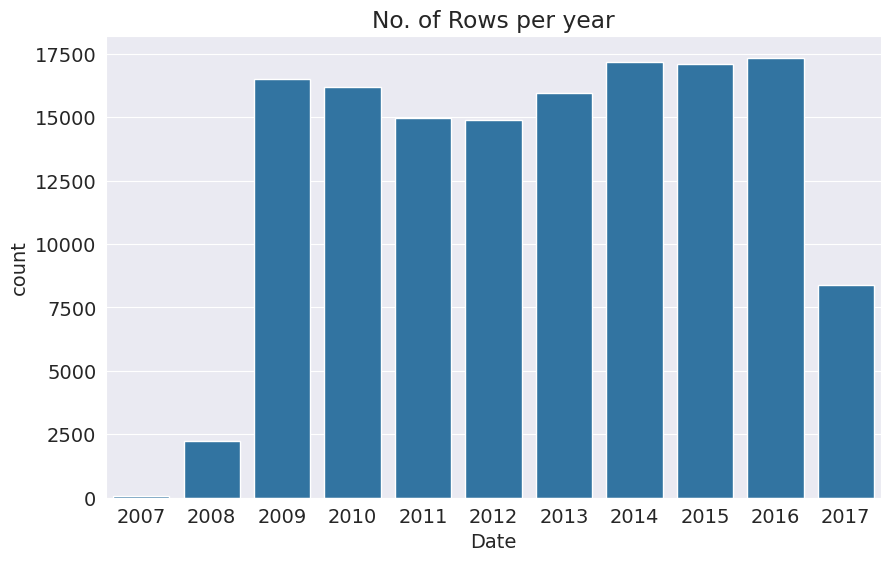

In [30]:
plt.title('No. of Rows per year')
sns.countplot(x = pd.to_datetime(raw_df.Date).dt.year)

What we can do is use the data till 2014 as training set and 2015 as validation set and 2016 and 2017 as test set.

We are going to predict the weather for 2018 and 2019

In [31]:
year = pd.to_datetime(raw_df.Date).dt.year
train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

print(f"train_df.shape: {train_df.shape}")
print(f"val_df.shape: {val_df.shape}")
print(f"test_df.shape: {test_df.shape}")

train_df.shape: (97988, 23)
val_df.shape: (17089, 23)
test_df.shape: (25710, 23)


In [32]:
train_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
144548  2014-12-27    Uluru     16.9     33.2       0.0          NaN   
144549  2014-12-28    Uluru     15.1     36.8       0.0          NaN   
144550  2014-12-29    Uluru     17.3     37.8       0.0          NaN   
144551  2014-12-30    Uluru     20.1     38.5       0.0          NaN   
144552  2014-12-31    Uluru     22.5     39.6       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
144548       NaN         SSE           43.0        ESE  ...        22.0   
144549       NaN          NE           31.0        ENE  ...        16.0   
144550       NaN         ESE           39.0        ESE  ...        15.0   
144551       NaN         ESE           43.0        ESE  ...        22.0   
144552       NaN         WNW           76.0        ENE  ...        16.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
144548         13.0       1014.1       1009.8       NaN       NaN     23.7   
144549          8.0       1012.6       1007.6       NaN       NaN     28.9   
144550          8.0       1011.9       1008.0       NaN       NaN     29.7   
144551          9.0       1014.0       1009.2       NaN       NaN     29.8   
144552          9.0       1012.1       1006.2       NaN       NaN     30.1   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
144548     31.8         No            No  
144549     34.8         No            No  
144550     35.7         No            No  
144551     37.2         No            No  
144552     37.4         No            No  

[97988 rows x 23 columns]

In [33]:
val_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
2133    2015-01-01   Albury     11.4     33.5       0.0          NaN   
2134    2015-01-02   Albury     15.5     39.6       0.0          NaN   
2135    2015-01-03   Albury     17.1     38.3       0.0          NaN   
2136    2015-01-04   Albury     26.0     33.1       0.0          NaN   
2137    2015-01-05   Albury     19.0     35.2       0.0          NaN   
...            ...      ...      ...      ...       ...          ...   
144913  2015-12-27    Uluru     20.5     34.7       0.0          NaN   
144914  2015-12-28    Uluru     18.0     36.4       0.0          NaN   
144915  2015-12-29    Uluru     17.5     37.1       0.0          NaN   
144916  2015-12-30    Uluru     20.0     38.9       0.0          NaN   
144917  2015-12-31    Uluru     19.3     37.4       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
2133         NaN         WSW           30.0        ESE  ...        45.0   
2134         NaN          NE           56.0        ESE  ...        45.0   
2135         NaN         NNE           48.0         NE  ...        35.0   
2136         NaN         NNE           41.0        ESE  ...        46.0   
2137         NaN           E           33.0        SSE  ...        60.0   
...          ...         ...            ...        ...  ...         ...   
144913       NaN           E           52.0        ESE  ...        23.0   
144914       NaN         ESE           54.0          E  ...        17.0   
144915       NaN           E           56.0          E  ...        12.0   
144916       NaN           E           59.0          E  ...        12.0   
144917       NaN          SE           56.0        ESE  ...        46.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
2133           14.0       1013.5       1011.0       NaN       NaN     21.0   
2134           12.0       1016.0       1012.4       NaN       NaN     25.6   
2135           19.0       1017.9       1012.3       NaN       NaN     29.2   
2136           37.0       1013.6       1012.1       8.0       5.0     27.4   
2137           34.0       1017.4       1014.7       8.0       NaN     25.6   
...             ...          ...          ...       ...       ...      ...   
144913         12.0       1013.2       1010.1       NaN       NaN     24.3   
144914          7.0       1014.7       1010.9       NaN       NaN     26.7   
144915          7.0       1012.6       1007.5       NaN       NaN     28.1   
144916         12.0       1007.2       1002.6       NaN       1.0     31.3   
144917         18.0       1007.3       1003.7       NaN       NaN     25.8   

        Temp3pm  RainToday  RainTomorrow  
2133       32.7         No            No  
2134       38.2         No            No  
2135       37.0         No            No  
2136       30.9         No            No  
2137       32.5         No            No  
...         ...        ...           ...  
144913     33.0         No            No  
144914     35.0         No            No  
144915     34.7         No            No  
144916     38.4         No            No  
144917     35.8         No            No  

[17089 rows x 23 columns]

In [34]:
test_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
2498    2016-01-01   Albury     20.4     37.6       0.0          NaN   
2499    2016-01-02   Albury     20.9     33.6       0.4          NaN   
2500    2016-01-03   Albury     18.4     23.1       2.2          NaN   
2501    2016-01-04   Albury     17.3     23.7      15.6          NaN   
2502    2016-01-05   Albury     15.5     22.9       6.8          NaN   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
2498         NaN         ENE           54.0        NaN  ...        46.0   
2499         NaN         SSE           50.0        SSE  ...        54.0   
2500         NaN         ENE           48.0        ESE  ...        62.0   
2501         NaN         SSE           39.0         SE  ...        74.0   
2502         NaN         ENE           31.0         SE  ...        92.0   
...          ...         ...            ...        ...  ...         ...   
145454       NaN           E           31.0        ESE  ...        59.0   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
2498           17.0       1013.4       1009.2       7.0       3.0     26.1   
2499           30.0       1011.1       1008.4       8.0       8.0     24.8   
2500           67.0       1014.0       1014.8       8.0       8.0     21.8   
2501           65.0       1017.9       1016.5       8.0       8.0     19.2   
2502           63.0       1016.3       1013.9       8.0       8.0     17.2   
...             ...          ...          ...       ...       ...      ...   
145454         27.0       1024.7       1021.2       NaN       NaN      9.4   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   

        Temp3pm  RainToday  RainTomorrow  
2498       36.7         No            No  
2499       31.7         No           Yes  
2500       19.5        Yes           Yes  
2501       21.6        Yes           Yes  
2502       22.2        Yes            No  
...         ...        ...           ...  
145454     20.9         No            No  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  

[25710 rows x 23 columns]

Let's identify the input and traget columns

In [35]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [36]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [37]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [38]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [39]:
train_inputs

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury     13.4     22.9       0.6          NaN       NaN   
1        Albury      7.4     25.1       0.0          NaN       NaN   
2        Albury     12.9     25.7       0.0          NaN       NaN   
3        Albury      9.2     28.0       0.0          NaN       NaN   
4        Albury     17.5     32.3       1.0          NaN       NaN   
...         ...      ...      ...       ...          ...       ...   
144548    Uluru     16.9     33.2       0.0          NaN       NaN   
144549    Uluru     15.1     36.8       0.0          NaN       NaN   
144550    Uluru     17.3     37.8       0.0          NaN       NaN   
144551    Uluru     20.1     38.5       0.0          NaN       NaN   
144552    Uluru     22.5     39.6       0.0          NaN       NaN   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  \
0                W           44.0          W        WNW  ...          24.0   
1              WNW           44.0        NNW        WSW  ...          22.0   
2              WSW           46.0          W        WSW  ...          26.0   
3               NE           24.0         SE          E  ...           9.0   
4                W           41.0        ENE         NW  ...          20.0   
...            ...            ...        ...        ...  ...           ...   
144548         SSE           43.0        ESE        SSE  ...          26.0   
144549          NE           31.0        ENE         SW  ...          20.0   
144550         ESE           39.0        ESE        SSE  ...           9.0   
144551         ESE           43.0        ESE        SSW  ...          17.0   
144552         WNW           76.0        ENE        SSW  ...          13.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0              71.0         22.0       1007.7       1007.1       8.0   
1              44.0         25.0       1010.6       1007.8       NaN   
2              38.0         30.0       1007.6       1008.7       NaN   
3              45.0         16.0       1017.6       1012.8       NaN   
4              82.0         33.0       1010.8       1006.0       7.0   
...             ...          ...          ...          ...       ...   
144548         22.0         13.0       1014.1       1009.8       NaN   
144549         16.0          8.0       1012.6       1007.6       NaN   
144550         15.0          8.0       1011.9       1008.0       NaN   
144551         22.0          9.0       1014.0       1009.2       NaN   
144552         16.0          9.0       1012.1       1006.2       NaN   

        Cloud3pm  Temp9am  Temp3pm  RainToday  
0            NaN     16.9     21.8         No  
1            NaN     17.2     24.3         No  
2            2.0     21.0     23.2         No  
3            NaN     18.1     26.5         No  
4            8.0     17.8     29.7         No  
...          ...      ...      ...        ...  
144548       NaN     23.7     31.8         No  
144549       NaN     28.9     34.8         No  
144550       NaN     29.7     35.7         No  
144551       NaN     29.8     37.2         No  
144552       NaN     30.1     37.4         No  

[97988 rows x 21 columns]

In [40]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

In [41]:
test_targets

2498       No
2499      Yes
2500      Yes
2501      Yes
2502       No
         ... 
145454     No
145455     No
145456     No
145457     No
145458     No
Name: RainTomorrow, Length: 25710, dtype: object

Now it is better to pick up numeric column and categorical columns

In [42]:
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [43]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97674.000000  97801.000000  97988.000000  61657.000000  57942.000000   
mean      12.007831     23.022202      2.372935      5.289991      7.609004   
std        6.347175      6.984397      8.518819      3.952010      3.788813   
min       -8.500000     -4.100000      0.000000      0.000000      0.000000   
25%        7.500000     17.900000      0.000000      2.600000      4.800000   
50%       11.800000     22.400000      0.000000      4.600000      8.500000   
75%       16.600000     27.900000      0.800000      7.200000     10.600000   
max       33.900000     48.100000    371.000000     82.400000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   91160.000000  97114.000000  96919.000000  96936.000000  96872.000000   
mean       40.215873     14.092263     18.764608     68.628745     51.469547   
std        13.697967      8.984203      8.872398     19.003097     20.756113   
min         6.000000      0.000000      0.000000      0.000000      0.000000   
25%        31.000000      7.000000     13.000000     57.000000     37.000000   
50%        39.000000     13.000000     19.000000     70.000000     52.000000   
75%        48.000000     19.000000     24.000000     83.000000     66.000000   
max       135.000000     87.000000     87.000000    100.000000    100.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  88876.000000  88857.000000  63000.000000  61966.000000  97414.000000   
mean    1017.513734   1015.132352      4.302952      4.410677     16.835126   
std        7.072510      6.997072      2.866634      2.693370      6.404586   
min      980.500000    979.000000      0.000000      0.000000     -5.900000   
25%     1012.800000   1010.400000      1.000000      2.000000     12.200000   
50%     1017.500000   1015.100000      5.000000      5.000000     16.600000   
75%     1022.300000   1019.900000      7.000000      7.000000     21.400000   
max     1041.000000   1039.600000      9.000000      9.000000     40.200000   

            Temp3pm  
count  97392.000000  
mean      21.540138  
std        6.831612  
min       -5.100000  
25%       16.600000  
50%       20.900000  
75%       26.200000  
max       46.100000

In [44]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [45]:
train_inputs['WindGustDir'].info()

<class 'pandas.core.series.Series'>
Index: 97988 entries, 0 to 144552
Series name: WindGustDir
Non-Null Count  Dtype 
--------------  ----- 
91120 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


## Imputing Missing Numeric Data

Machine Learning Models can't work with missing data. The process of filling missing values is called imputation

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with average value in the column using the `SimpleImputer` class from `sklearn.impute`

In [46]:
imputer = SimpleImputer(strategy = 'mean')

In [47]:
raw_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

In [48]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

In [49]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

In [50]:
list(imputer.statistics_)

[np.float64(12.18482386562048),
 np.float64(23.235120301822324),
 np.float64(2.349974074310839),
 np.float64(5.472515506887154),
 np.float64(7.630539861047281),
 np.float64(39.97051988882308),
 np.float64(13.990496092519967),
 np.float64(18.631140782316862),
 np.float64(68.82683277087672),
 np.float64(51.44928834695453),
 np.float64(1017.6545771543717),
 np.float64(1015.2579625879797),
 np.float64(4.431160817585808),
 np.float64(4.499250233195188),
 np.float64(16.98706638787991),
 np.float64(21.69318269001107)]

In [51]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [52]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [53]:
train_inputs.describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean      12.008398     23.022609      2.372935      5.357666      7.617805   
std        6.337005      6.977735      8.518819      3.136123      2.913498   
min       -8.500000     -4.100000      0.000000      0.000000      0.000000   
25%        7.500000     17.900000      0.000000      3.800000      7.500000   
50%       11.800000     22.400000      0.000000      5.472516      7.630540   
75%       16.600000     27.900000      0.800000      5.600000      9.200000   
max       33.900000     48.100000    371.000000     82.400000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       40.198776     14.091355     18.763152     68.630871     51.469317   
std        13.212242      8.944051      8.823879     18.900823     20.637576   
min         6.000000      0.000000      0.000000      0.000000      0.000000   
25%        31.000000      7.000000     13.000000     57.000000     37.000000   
50%        39.000000     13.000000     19.000000     69.000000     52.000000   
75%        46.000000     19.000000     24.000000     83.000000     65.000000   
max       135.000000     87.000000     87.000000    100.000000    100.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean    1017.526831   1015.144057      4.348731      4.443238     16.836016   
std        6.735769      6.663187      2.299375      2.142256      6.385810   
min      980.500000    979.000000      0.000000      0.000000     -5.900000   
25%     1013.400000   1010.900000      3.000000      3.000000     12.200000   
50%     1017.654577   1015.257963      4.431161      4.499250     16.600000   
75%     1021.800000   1019.300000      6.000000      6.000000     21.300000   
max     1041.000000   1039.600000      9.000000      9.000000     40.200000   

            Temp3pm  
count  97988.000000  
mean      21.541069  
std        6.810814  
min       -5.100000  
25%       16.600000  
50%       21.000000  
75%       26.100000  
max       46.100000

## Scaling Numeric Features

Another good step is to scale the values to a small range of values e.g(0, 1) or (-1, 1). Scaling prevents outliers from disrupting the data and keeping the model out of bias.

In [54]:
scaler = MinMaxScaler()

In [55]:
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

In [56]:
print('Minimum')
list(scaler.data_min_)

Minimum


[np.float64(-8.5),
 np.float64(-4.8),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(6.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(980.5),
 np.float64(977.1),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(-7.2),
 np.float64(-5.4)]

In [57]:
print('Maximum')
list(scaler.data_max_)

Maximum


[np.float64(33.9),
 np.float64(48.1),
 np.float64(371.0),
 np.float64(145.0),
 np.float64(14.5),
 np.float64(135.0),
 np.float64(130.0),
 np.float64(87.0),
 np.float64(100.0),
 np.float64(100.0),
 np.float64(1041.0),
 np.float64(1039.6),
 np.float64(9.0),
 np.float64(9.0),
 np.float64(40.2),
 np.float64(46.7)]

In [58]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [59]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.483689      0.525947      0.006396      0.036949      0.525366   
std        0.149458      0.131904      0.022962      0.021628      0.200931   
min        0.000000      0.013233      0.000000      0.000000      0.000000   
25%        0.377358      0.429112      0.000000      0.026207      0.517241   
50%        0.478774      0.514178      0.000000      0.037741      0.526244   
75%        0.591981      0.618147      0.002156      0.038621      0.634483   
max        1.000000      1.000000      1.000000      0.568276      0.986207   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean        0.265107      0.108395      0.215668      0.686309      0.514693   
std         0.102420      0.068800      0.101424      0.189008      0.206376   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.193798      0.053846      0.149425      0.570000      0.370000   
50%         0.255814      0.100000      0.218391      0.690000      0.520000   
75%         0.310078      0.146154      0.275862      0.830000      0.650000   
max         1.000000      0.669231      1.000000      1.000000      1.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.612014      0.608705      0.483192      0.493693      0.507089   
std        0.111335      0.106611      0.255486      0.238028      0.134722   
min        0.000000      0.030400      0.000000      0.000000      0.027426   
25%        0.543802      0.540800      0.333333      0.333333      0.409283   
50%        0.614125      0.610527      0.492351      0.499917      0.502110   
75%        0.682645      0.675200      0.666667      0.666667      0.601266   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Temp3pm  
count  97988.000000  
mean       0.517103  
std        0.130726  
min        0.005758  
25%        0.422265  
50%        0.506718  
75%        0.604607  
max        0.988484

## Encoding Categorical Data

Since Machine Learning algorithms only work with numeric data, we need to convert our categorical data to numerical data. A commin technique is to `use one hot encoding`

In [60]:
raw_df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [61]:
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

In [62]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [63]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

In [64]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

In [65]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/tmp/ipython-input-1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1584174743.py:1: PerformanceWarning:

In [66]:
pd.set_option('display.max_columns', None)

In [67]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
2498     Albury  0.681604  0.801512  0.000000     0.037741  0.526244   
2499     Albury  0.693396  0.725898  0.001078     0.037741  0.526244   
2500     Albury  0.634434  0.527410  0.005930     0.037741  0.526244   
2501     Albury  0.608491  0.538752  0.042049     0.037741  0.526244   
2502     Albury  0.566038  0.523629  0.018329     0.037741  0.526244   
...         ...       ...       ...       ...          ...       ...   
145454    Uluru  0.283019  0.502836  0.000000     0.037741  0.526244   
145455    Uluru  0.266509  0.533081  0.000000     0.037741  0.526244   
145456    Uluru  0.285377  0.568998  0.000000     0.037741  0.526244   
145457    Uluru  0.327830  0.599244  0.000000     0.037741  0.526244   
145458    Uluru  0.384434  0.601134  0.000000     0.037741  0.526244   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
2498           ENE       0.372093        NaN        ESE      0.000000   
2499           SSE       0.341085        SSE         SE      0.069231   
2500           ENE       0.325581        ESE        ENE      0.084615   
2501           SSE       0.255814         SE        SSE      0.069231   
2502           ENE       0.193798         SE        SSE      0.046154   
...            ...            ...        ...        ...           ...   
145454           E       0.193798        ESE          E      0.115385   
145455           E       0.193798         SE        ENE      0.100000   
145456         NNW       0.124031         SE          N      0.100000   
145457           N       0.240310         SE        WNW      0.069231   
145458          SE       0.170543        SSE          N      0.100000   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
2498        0.080460         0.46         0.17     0.543802       0.5136   
2499        0.195402         0.54         0.30     0.505785       0.5008   
2500        0.448276         0.62         0.67     0.553719       0.6032   
2501        0.195402         0.74         0.65     0.618182       0.6304   
2502        0.103448         0.92         0.63     0.591736       0.5888   
...              ...          ...          ...          ...          ...   
145454      0.149425         0.59         0.27     0.730579       0.7056   
145455      0.126437         0.51         0.24     0.728926       0.6912   
145456      0.103448         0.56         0.21     0.710744       0.6720   
145457      0.103448         0.53         0.24     0.669421       0.6352   
145458      0.080460         0.51         0.24     0.642975       0.6304   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
2498    0.777778  0.333333  0.702532  0.808061        No                0.0   
2499    0.888889  0.888889  0.675105  0.712092        No                0.0   
2500    0.888889  0.888889  0.611814  0.477927       Yes                0.0   
2501    0.888889  0.888889  0.556962  0.518234       Yes                0.0   
2502    0.888889  0.888889  0.514768  0.529750       Yes                0.0   
...          ...       ...       ...       ...       ...                ...   
145454  0.492351  0.499917  0.350211  0.504798        No                0.0   
145455  0.492351  0.499917  0.364979  0.533589        No                0.0   
145456  0.492351  0.499917  0.381857  0.573896        No                0.0   
145457  0.492351  0.499917  0.415612  0.604607        No                0.0   
145458  0.333333  0.222222  0.470464  0.602687        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
2498                0.0              1.0                    0.0   
2499                0.0              1.0                    0.0   
2500                0.0              1.0                    0.0   
2501                0.0              1.0                    0.0   
2502                0.0              1.0                    0.0   
.

## Saving Processed Data to Disk

It is generally usefull to save our data before moving forward to avoid processing on large datasets.

In [68]:
print(f"train_inputs: {train_inputs.shape}")
print(f"train_targets: {train_targets.shape}")
print(f"val_inputs: {val_inputs.shape}")
print(f"val_targets: {val_targets.shape}")
print(f"test_inputs: {test_inputs.shape}")
print(f"test_targets: {test_targets.shape}")

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


Let's install pyarrow to save our progress

In [69]:
!pip install pyarrow --quiet

In [70]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')

In [71]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: user 46.1 ms, sys: 8.64 ms, total: 54.7 ms
Wall time: 65.9 ms


We can read the data back using `pd.read_parquet`

In [72]:
%%time
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

CPU times: user 292 ms, sys: 138 ms, total: 429 ms
Wall time: 307 ms


In [73]:
# Verify the data was loaded properly
print(f"train_inputs: {train_inputs.shape}")
print(f"train_targets: {train_targets.shape}")
print(f"val_inputs: {val_inputs.shape}")
print(f"val_targets: {val_targets.shape}")
print(f"test_inputs: {test_inputs.shape}")
print(f"test_targets: {test_targets.shape}")

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


## Train a Logistic Regression Model

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model:

* we take linear combination (or weighted sum of the input features)
* we apply the sigmoid function to the result to obtain a number between 0 and 1.
* this number represents the probability of the input being classified as "Yes".
* instead of RMSE, the cross entropy loss function is used to evaluate the results.

In [74]:
model = LogisticRegression(solver = 'liblinear')

In [75]:
%%time
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

CPU times: user 1.85 s, sys: 87.4 ms, total: 1.94 s
Wall time: 2.15 s


LogisticRegression(solver='liblinear')

`model.fit` uses the following workflow for training the model

1. We initialize a model with random parameters (weights and biases)
2. We pass some inouts into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.
4. We use an optimization technique (like least squares, gradient descent etc) to reduce the loss by adjusting the weights and biases of the model.
5. We repeat steps 1 to 4 till the predictions from the model are good enough

In [76]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [77]:
print(model.coef_.tolist())

[[0.8986324151652026, -2.8799288484272725, 3.1627783941533836, 0.854233199097419, -1.6713967645743446, 6.764401997617562, -0.9423193916231418, -1.4284332004350349, 0.32288705993860534, 5.995309618290915, 5.463842155596162, -9.17680276828724, -0.16230118601099724, 1.2876575875289866, 0.4747071394851873, 2.021436091461751, 0.6016503155225178, -0.5524816082098337, 0.4781437731763531, 0.007665268046942364, 0.34681451580237477, -0.35227817340007966, 0.179711399916397, 0.44048778217353635, -0.01398114695470229, 0.02894542200290951, 0.25814954936639495, -0.02120462546599252, -0.042796507118596186, -0.4831421250609206, -0.13756199126704258, -0.5760603459151452, -0.7875267102260608, -0.2554043193119793, -0.32888557652985945, -0.5690061685416732, 0.08183012548576335, 0.01337885424500912, 0.06412739003123773, -0.902055123317936, -0.44432923536376756, 0.008522707040877443, -0.46061421444037337, -0.46551869427571413, -0.06950053405236756, 0.19116044505301996, 0.45047653558120854, 0.6081202596542495

In [78]:
print(model.intercept_)

[-2.44956109]


In [79]:
n = len(model.coef_.tolist())

weight_df = pd.DataFrame({
    'features': numeric_cols + encoded_cols,
    'weight': model.coef_.tolist()[0]
})

<Axes: xlabel='weight', ylabel='features'>

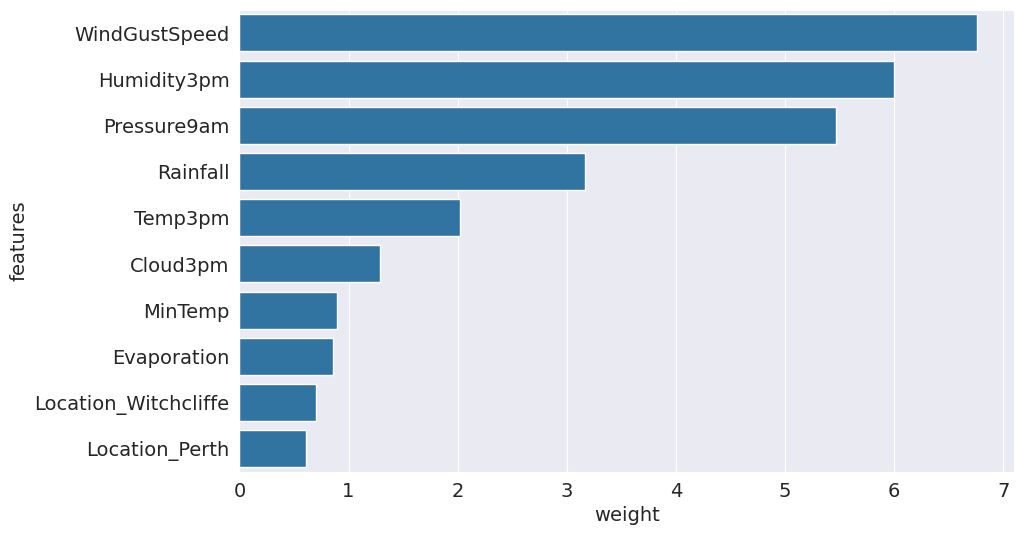

In [80]:
sns.barplot(data = weight_df.sort_values('weight', ascending = False).head(10), x = 'weight', y = 'features')

## Making Predictions and Evaluating the Model

Now that we have trained the model, it's time for predictions

In [81]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [82]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
2498     Albury  0.681604  0.801512  0.000000     0.037741  0.526244   
2499     Albury  0.693396  0.725898  0.001078     0.037741  0.526244   
2500     Albury  0.634434  0.527410  0.005930     0.037741  0.526244   
2501     Albury  0.608491  0.538752  0.042049     0.037741  0.526244   
2502     Albury  0.566038  0.523629  0.018329     0.037741  0.526244   
...         ...       ...       ...       ...          ...       ...   
145454    Uluru  0.283019  0.502836  0.000000     0.037741  0.526244   
145455    Uluru  0.266509  0.533081  0.000000     0.037741  0.526244   
145456    Uluru  0.285377  0.568998  0.000000     0.037741  0.526244   
145457    Uluru  0.327830  0.599244  0.000000     0.037741  0.526244   
145458    Uluru  0.384434  0.601134  0.000000     0.037741  0.526244   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
2498           ENE       0.372093       None        ESE      0.000000   
2499           SSE       0.341085        SSE         SE      0.069231   
2500           ENE       0.325581        ESE        ENE      0.084615   
2501           SSE       0.255814         SE        SSE      0.069231   
2502           ENE       0.193798         SE        SSE      0.046154   
...            ...            ...        ...        ...           ...   
145454           E       0.193798        ESE          E      0.115385   
145455           E       0.193798         SE        ENE      0.100000   
145456         NNW       0.124031         SE          N      0.100000   
145457           N       0.240310         SE        WNW      0.069231   
145458          SE       0.170543        SSE          N      0.100000   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
2498        0.080460         0.46         0.17     0.543802       0.5136   
2499        0.195402         0.54         0.30     0.505785       0.5008   
2500        0.448276         0.62         0.67     0.553719       0.6032   
2501        0.195402         0.74         0.65     0.618182       0.6304   
2502        0.103448         0.92         0.63     0.591736       0.5888   
...              ...          ...          ...          ...          ...   
145454      0.149425         0.59         0.27     0.730579       0.7056   
145455      0.126437         0.51         0.24     0.728926       0.6912   
145456      0.103448         0.56         0.21     0.710744       0.6720   
145457      0.103448         0.53         0.24     0.669421       0.6352   
145458      0.080460         0.51         0.24     0.642975       0.6304   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
2498    0.777778  0.333333  0.702532  0.808061        No                0.0   
2499    0.888889  0.888889  0.675105  0.712092        No                0.0   
2500    0.888889  0.888889  0.611814  0.477927       Yes                0.0   
2501    0.888889  0.888889  0.556962  0.518234       Yes                0.0   
2502    0.888889  0.888889  0.514768  0.529750       Yes                0.0   
...          ...       ...       ...       ...       ...                ...   
145454  0.492351  0.499917  0.350211  0.504798        No                0.0   
145455  0.492351  0.499917  0.364979  0.533589        No                0.0   
145456  0.492351  0.499917  0.381857  0.573896        No                0.0   
145457  0.492351  0.499917  0.415612  0.604607        No                0.0   
145458  0.333333  0.222222  0.470464  0.602687        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
2498                0.0              1.0                    0.0   
2499                0.0              1.0                    0.0   
2500                0.0              1.0                    0.0   
2501                0.0              1.0                    0.0   
2502                0.0              1.0                    0.0   
.

In [83]:
train_preds = model.predict(X_train)

In [84]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [85]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

In [86]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94401311, 0.05598689],
       [0.94074304, 0.05925696],
       [0.96093735, 0.03906265],
       ...,
       [0.98749147, 0.01250853],
       [0.98334725, 0.01665275],
       [0.87453712, 0.12546288]])

In [87]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [88]:
accuracy_score(train_targets, train_preds)

0.8519206433440829

In [89]:
confusion_matrix(train_targets, train_preds, normalize = 'true')

array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

In [96]:
def predict_and_plot(inputs, targets, name = ''):
  preds = model.predict(inputs)

  accuracy = accuracy_score(targets, preds)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  cf = confusion_matrix(targets, preds, normalize = 'true')
  plt.figure()
  sns.heatmap(cf, annot = True)
  plt.xlabel("Predictions")
  plt.ylabel("Target")
  plt.title(f"{name} Confusion Matrix")

  return preds

Accuracy: 85.19%


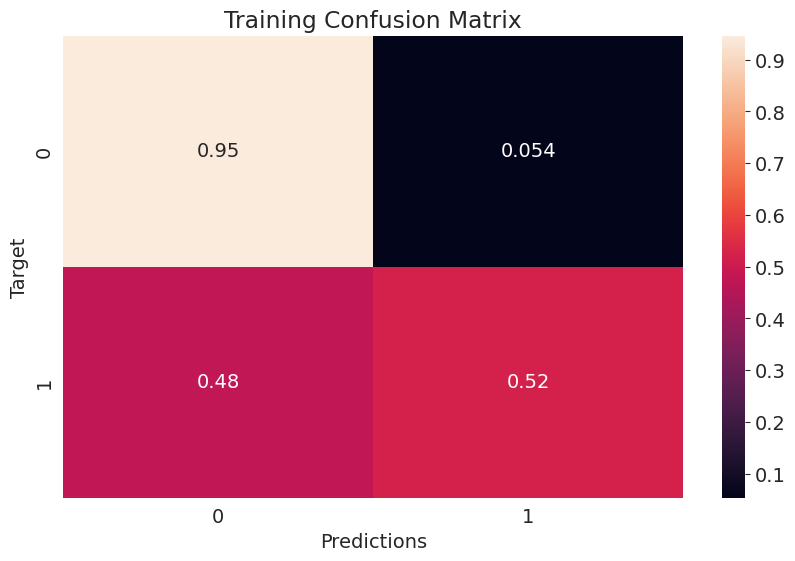

In [97]:
train_preds = predict_and_plot(X_train, train_targets, "Training")

Accuracy: 85.40%


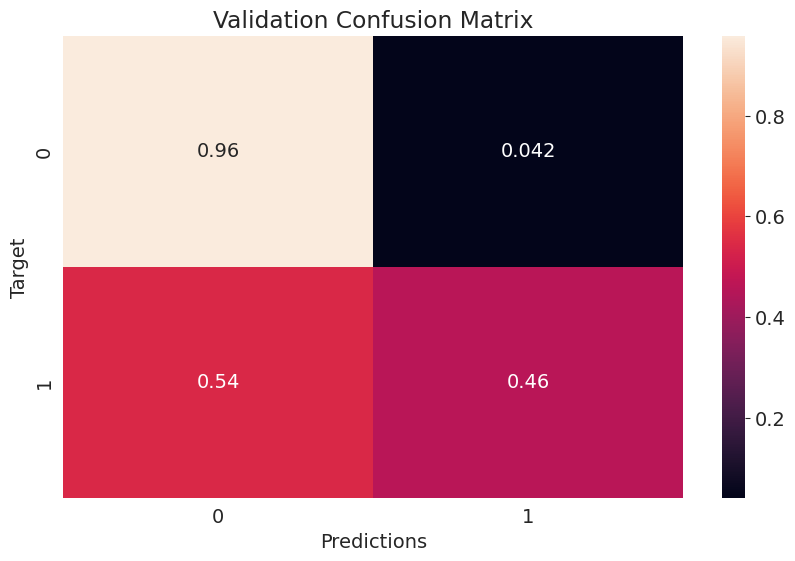

In [99]:
val_preds = predict_and_plot(X_val, val_targets, "Validation")

Accuracy: 84.20%


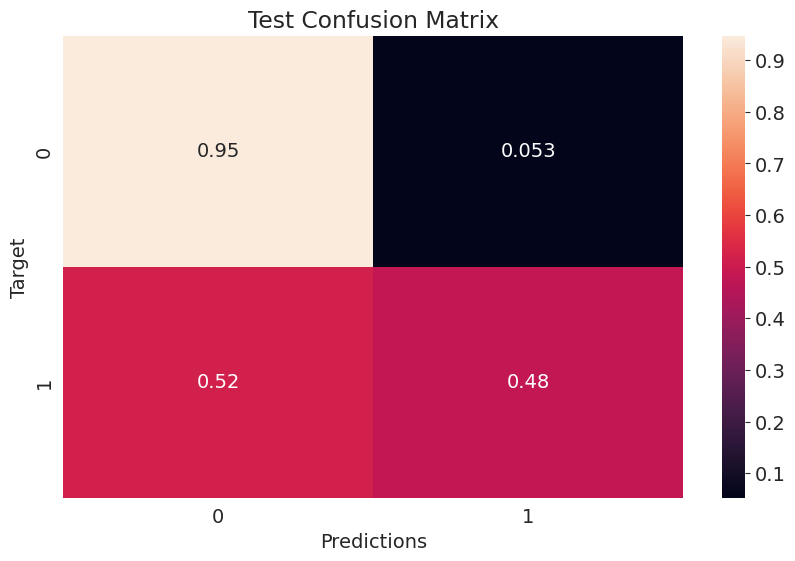

In [100]:
test_preds = predict_and_plot(X_test, test_targets, "Test")

A good way to verify whether a model has learned something useful is to compare it's results to a "random" or "dumb" model

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [101]:
def random_guests(inputs):
  return np.random.choice(["No", "Yes"], len(inputs))

In [102]:
def all_no(inputs):
  return np.full(len(inputs), "No")

Let's check the accuracies of these two models on the test case

In [103]:
accuracy_score(test_targets, random_guests(X_test))

0.49949436017113963

In [104]:
accuracy_score(test_targets, all_no(X_test))

0.7734344612991054

Making Predictions on a Single Point
Now that our model has been trained, we can make predictions on new data, imitating the real world data.

In [114]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

We have to convert the dictionary into Pandas dataframe, similar to `raw_df`. This can be done using a list containing the given dictionary to the pd.DataFrame constructor.

In [115]:
new_input_df = pd.DataFrame([new_input])

In [116]:
new_input_df

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2021-06-19  Katherine     23.2     33.2      10.2          4.2       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0         NNW           52.0         NW        NNE          13.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          20.0         89.0         58.0       1004.8       1001.5       8.0   

   Cloud3pm  Temp9am  Temp3pm RainToday  
0       5.0     25.7     33.0       Yes

Since now we've created the Pandas Dataframe with the same column as raw_df(except `RainTomorrow`, which needs to be predicted). The dataframe contains just one row of data, containing the given input.

We must now apply the same transmutatioin methods applied to the training data.

1. Imputation of missing values using the `imputer` created earlier.
2. Scaling numerical features using the `scaler` created earlier.
3. Encoding categorical features using the `encoder` created earlier.

In [117]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

/tmp/ipython-input-4090555460.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-4090555460.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-4090555460.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-4090555460.py:3: PerformanceWarning:

In [118]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.747642  0.718336  0.027493     0.028966  0.526244       0.356589   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0           0.1      0.229885         0.89         0.58     0.401653   

   Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  Location_Adelaide  \
0       0.3904  0.888889  0.555556  0.694093  0.737044                0.0   

   Location_Albany  Location_Albury  Location_AliceSprings  \
0              0.0              0.0                    0.0   

   Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                     0.0                0.0               0.0   

   Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  \
0                0.0              0.0                0.0             0.0   

   Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0                    0.0                0.0              0.0   

   Location_GoldCoast  Location_Hobart  Location_Katherine  \
0                 0.0              0.0                 1.0   

   Location_Launceston  Location_Melbourne  Location_MelbourneAirport  \
0                  0.0                 0.0                        0.0   

   Location_Mildura  Location_Moree  Location_MountGambier  \
0               0.0             0.0                    0.0   

   Location_MountGinini  Location_Newcastle  Location_Nhil  \
0                   0.0                 0.0            0.0   

   Location_NorahHead  Location_NorfolkIsland  Location_Nuriootpa  \
0                 0.0                     0.0                 0.0   

   Location_PearceRAAF  Location_Penrith  Location_Perth  \
0                  0.0               0.0             0.0   

   Location_PerthAirport  Location_Portland  Location_Richmond  Location_Sale  \
0                    0.0                0.0                0.0            0.0   

   Location_SalmonGums  Location_Sydney  Location_SydneyAirport  \
0                  0.0              0.0                     0.0   

   Location_Townsville  Location_Tuggeranong  Location_Uluru  \
0                  0.0                   0.0             0.0   

   Location_WaggaWagga  Location_Walpole  Location_Watsonia  \
0                  0.0               0.0                0.0   

   Location_Williamtown  Location_Witchcliffe  Location_Wollongong  \
0                   0.0                   0.0                  0.0   

   Location_Woomera  WindGustDir_E  WindGustDir_ENE  WindGustDir_ESE  \
0               0.0            0.0              0.0              0.0   

   WindGustDir_N  WindGustDir_NE  WindGustDir_NNE  WindGustDir_NNW  \
0            0.0             0.0              0.0              1.0   

   WindGustDir_NW  WindGustDir_S  WindGustDir_SE  WindGustDir_SSE  \
0             0.0            0.0             0.0              0.0   

   WindGustDir_SSW  WindGustDir_SW  WindGustDir_W  WindGustDir_WNW  \
0              0.0             0.0            0.0              0.0   

   WindGustDir_WSW  WindGustDir_nan  WindDir9am_E  WindDir9am_ENE  \
0              0.0              0.0           0.0             0.0   

   WindDir9am_ESE  WindDir9am_N  WindDir9am_NE  WindDir9am_NNE  \
0             0.0           0.0            0.0             0.0   

   WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  WindDir9am_SSE  \
0             0.0            1.0           0.0            0.0             0.0   

   WindDir9am_SSW  WindDir9am_SW  WindDir9am_W  WindDir9am_WNW  \
0             0.0            0.0           0.0             0.0   

   WindDir9am_WSW  WindDir9am_nan  WindDir3pm_E  WindDir3pm_ENE  \
0             0.0             0.0           0.0             0.0   

   WindDir3pm_ESE  WindDir3pm_N  WindDir3pm_NE  WindDir3pm_NNE  \
0             0.0           0.0            0.0             1.0   

   WindDir3pm_NNW  WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  \
0             0.0            0.0           0.0           

In [120]:
prediction = model.predict(X_new_input)[0]
prediction

'Yes'

In [122]:
prob = model.predict_proba(X_new_input)[0]
prob

array([0.48103629, 0.51896371])

Let's define a helper function to make predictions for individual inputs

In [137]:
def predict_input(single_input):
  input_df = pd.DataFrame([single_input])

  numeric_data = pd.DataFrame(
      scaler.transform(imputer.transform(input_df[numeric_cols])),
      columns = numeric_cols
  )

  encoded_data = pd.DataFrame(
      encoder.transform(input_df[categorical_cols]),
      columns = encoded_cols
  )

  X_input = pd.concat([numeric_data, encoded_data], axis = 1)

  pred = model.predict(X_input)[0]
  prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]

  return pred, prob

In [138]:
new_input = {'Date': '2021-06-19',
             'Location': 'NorfolkIsland',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [139]:
predict_input(new_input)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



('Yes', np.float64(0.5981828308232242))

In [127]:
raw_df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)